# Transfer Learning on kidney stone images
This notebook contains the code applied on kidney stone mixed images in order to classify them in six different types. A transfer learning approach is used from the ImageNet dataset to our dataset, over a resenet50 architecture.
You can read more about the results in: https://arxiv.org/abs/2210.13654

In [ ]:
#Connect with drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#GPU info for colab notebook
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 29 20:12:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torchvision.models import resnet50, ResNet50_Weights,ResNet101_Weights
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
#Fixing a dataloader generator for reproducibility

MANUAL_SEED = 3407
G = torch.Generator()
G.manual_seed(MANUAL_SEED)
np.random.seed(3407)
random.seed(3407)

In [ ]:
import os
import time

import torch
import torch.nn.functional as F


import torchvision
from torchvision import datasets,transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd


def split_dataset(datasets,split_proportion,to_split = 'train'):

    '''
    Function that splits any dataset into a principal subset and a smaller subset
    based on a split proportion.
    Parameters
    ----------
    datasets : dict
        dictionary containing the dataset to split.
    to_split : str
        string representing the key of the dataset to split contained in datasets. Default: 'train'
    split_proportion: float
        float between 0-1 that represents the proportion of the main dataset that will be
        the new splitted one.
    Returns
    -------
    tuple
        (main subset, splitted subset)
    '''

    main_indices, subset_indices = train_test_split(list(range(len(datasets[to_split].targets))), test_size=split_proportion,
                                                  stratify=datasets[to_split].targets)

    main_split = torch.utils.data.Subset(datasets[to_split], main_indices)
    subset_split = torch.utils.data.Subset(datasets[to_split], subset_indices)

    return main_split,subset_split


#Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),

        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Directories of your train and test dataset
data_dir_train = "/content/drive/MyDrive/Jonathan El-Beze (6 classes - w256 - 1k)/SUR/train"
data_dir_test = "/content/drive/MyDrive/Jonathan El-Beze (6 classes - w256 - 1k)/SEC/test"

#Create datasets from the directions
image_datasets = {'train': datasets.ImageFolder(data_dir_train, data_transforms['train']),
                      'test': datasets.ImageFolder(data_dir_test, data_transforms['test'])
                      }

class_names = image_datasets['train'].classes

#Split the train dataset loaded before into train and valid
image_datasets['train'],image_datasets['valid'] = split_dataset(image_datasets,0.1,'train')

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= 24,
                                                  shuffle=True, generator=G) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



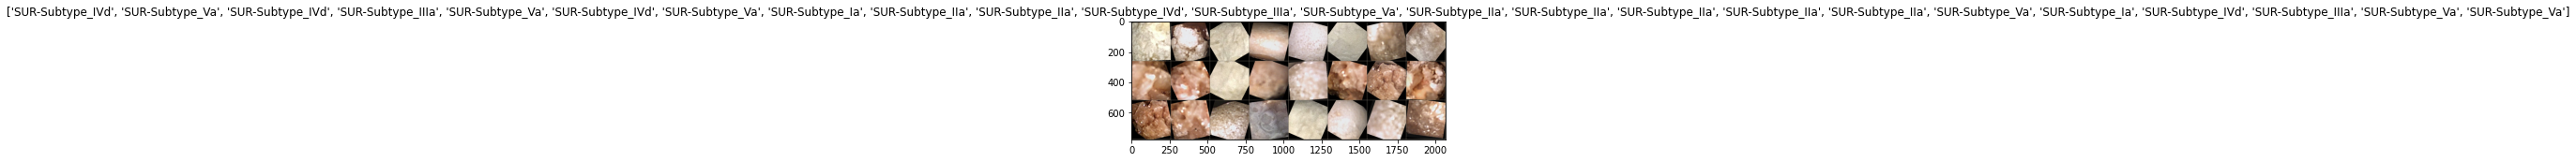

In [ ]:
# Visualize the images of a batch and its label
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_incorrects=0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_incorrects += torch.sum(preds!=labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_model_mdjeb=model

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    #Directory where you want to save your model as a .pth file
    FILE=f"/content/drive/MyDrive/Nuevos_experimentos/SECtrain_SURtest/trainsur_testsec2.pth"
    torch.save(best_model_mdjeb,FILE)
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
# Visualizing the model predictions
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds)
            print(labels)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                ax.set_xlabel(labels[j])
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
#load the resnet50 model with pre-trained weights
model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

#add some new layers
model_ft.fc=  nn.Sequential(


    nn.Flatten(),
    nn.BatchNorm1d(num_ftrs),
    nn.Linear(num_ftrs,768),
   nn.ReLU(),




   nn.BatchNorm1d(768),
   nn.Linear(768,256),
   nn.ReLU(),
   nn.Dropout(),

   nn.BatchNorm1d(256),
   nn.Linear(256,128),
   nn.ReLU(),
   nn.Dropout(),

   nn.BatchNorm1d(128),
   nn.Linear(128,6) #change the 6 to put the amount of outputs you want

)
model_ft=model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#optimizer_ft2=optim.Adam(model_ft.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#Architecture
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#train the model
model_surtrain_sectest= train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=30)

Epoch 0/29
----------
train Loss: 1.2633 Acc: 0.5090
valid Loss: 0.6649 Acc: 0.7625

Epoch 1/29
----------
train Loss: 0.7006 Acc: 0.7352
valid Loss: 0.4154 Acc: 0.8729

Epoch 2/29
----------
train Loss: 0.5493 Acc: 0.7951
valid Loss: 0.3051 Acc: 0.8875

Epoch 3/29
----------
train Loss: 0.4482 Acc: 0.8414
valid Loss: 0.2379 Acc: 0.9271

Epoch 4/29
----------
train Loss: 0.3419 Acc: 0.8829
valid Loss: 0.1844 Acc: 0.9417

Epoch 5/29
----------
train Loss: 0.2909 Acc: 0.8991
valid Loss: 0.1562 Acc: 0.9396

Epoch 6/29
----------
train Loss: 0.2518 Acc: 0.9241
valid Loss: 0.1465 Acc: 0.9479

Epoch 7/29
----------
train Loss: 0.2543 Acc: 0.9155
valid Loss: 0.1092 Acc: 0.9646

Epoch 8/29
----------
train Loss: 0.2367 Acc: 0.9301
valid Loss: 0.0818 Acc: 0.9771

Epoch 9/29
----------
train Loss: 0.2115 Acc: 0.9329
valid Loss: 0.0812 Acc: 0.9771

Epoch 10/29
----------
train Loss: 0.2176 Acc: 0.9324
valid Loss: 0.0728 Acc: 0.9792

Epoch 11/29
----------
train Loss: 0.1866 Acc: 0.9424
valid Loss

#Evaluate the model

In [ ]:
model_name = "/content/drive/MyDrive/Nuevos_experimentos/SECtrain_SURtest/trainsur_testsec2.pth" #path where you saved the trained model

model_conv = torch.load(model_name)
model_conv.eval()
with torch.no_grad():
  for i, (X_test, y) in enumerate(dataloaders['test']):
    X_test = X_test.to(device)

    logits = model_conv(X_test)


    pred = np.argmax(F.softmax(logits.cpu(), dim=1), 1)

    if i == 0:
      y_pred = pred
      y_test = y

    else:
      y_pred = np.hstack((y_pred, pred))
      y_test = np.hstack((y_test, y))


report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

df_report = pd.DataFrame(report).transpose()

output_name="/content/drive/MyDrive/Nuevos_experimentos/SECtrain_SURtest/trainsur_testsec2.csv" #path to save the metrics in a csv file

df_report.to_csv(output_name)